In [1]:
import numpy as np
import os
import sys
import shutil
nexus_path = os.path.abspath("/Users/users/nastase/Applications/NEXUS_python/NEXUS_1.0/")
sys.path.append(nexus_path)
bin_path = os.path.abspath("/Users/users/nastase/Applications/NEXUS_python/NEXUS_1.0/bin/")
sys.path.append(bin_path)
from density import readDensityHeader, writeDensityData
import re
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [2]:
gridsize = 512
sidelen = 106.5
snapnum = 133
data_directory = "/Users/users/nastase/PROJECT/DATA/nexus_outputs/MMF_outputs/"
base_path = "/Users/users/nastase/PROJECT/"

In [3]:

snap = il.snapshot.loadSubset(base_path, snapnum, 'dm', ["Coordinates", "ParticleIDs"])
positions_array = snap["Coordinates"]
ids_array = snap["ParticleIDs"]
positions_grid = ((positions_array - np.min(positions_array)) / (np.max(positions_array) - np.min(positions_array)) * gridsize) - 1

In [4]:
def giveheader(demoden,DTFEden,outputname,gridsize,sidelen):
    #First we read a file with a good header to edit
#     l = readDensityHeader("demo_density.a_den")
    l = readDensityHeader(demoden)
    #And we read the output from DTFE
    den = np.array(np.fromfile(DTFEden,dtype=np.float32))

    #And we put them in the header
    l.gridSize = np.array([gridsize,gridsize,gridsize])
    l.totalGrid = gridsize**3
    l.box = np.array([0.,sidelen,0.,sidelen,0.,sidelen])
    #Finally we write the new header with the density data to a new NEXUS-ready file
    writeDensityData(outputname,l,den)

In [5]:
def readNEXUS(densityFile,gridsize,vel=False,velFile=None):
    # here we wish to extract the 3 digits corresponding ot the snapshot number, such that we can save the files
    # in the same directory without overwriting
    
    pattern = r'(\d{3})\.a_den$'
    
    # Search for the pattern in the densityFile name
    match = re.search(pattern, densityFile)
    
    if match:
        # Extract the 3 digits
        digits = match.group(1)
#         print("Extracted digits: {digits}")
    else:
        print("No matching digits found before '.a_den'")
    
    #This function will read the files generated by runNEXUS and make them into numpy arrays
    #It can also read DTFE velocity files as an extra option
    #The order is as follows, it returns:
    #Densityfield, NEXUS_nodes, NEXUS_filaments, NEXUS_walls, Velocity (optional)
    #The NEXUS arrays can then be used for contours or converted into boolean arrays
    #Where all cells > 0 are part of the corresponding structure
    #Voids are located where the other three components are all 0 
    shape = (gridsize,gridsize,gridsize)
    denfield = np.fromfile(densityFile,dtype=np.float32)
    denfield = np.reshape(denfield[262:-2],shape)
    MMFn = np.fromfile(f"{data_directory}node_{digits}_clean.MMF",dtype=np.int16)
    MMFn = np.reshape(MMFn[527:-1],shape)
    MMFf = np.fromfile(f"{data_directory}fila_{digits}_clean.MMF",dtype=np.int16)
    MMFf = np.reshape(MMFf[527:-1],shape)
    MMFw = np.fromfile(f"{data_directory}wall_{digits}_clean.MMF",dtype=np.int16)
    MMFw = np.reshape(MMFw[527:-1],shape)
    #Correct for the z-axis missallignment of the density field wrt NEXUS
    def maxmean(densf,MMFfila,axisn,ran):
        k = np.zeros(ran)
        for i in range(ran):
            k[i] = np.mean(np.roll(densf,i,axis=axisn)[MMFfila>0])
        return np.argmax(k)
    
    shift = maxmean(denfield,MMFf,2,gridsize)
    denfield = np.roll(denfield,shift,axis=2)
    if vel==True:
        velo = np.fromfile(velFile,dtype=np.float32)
        k = np.reshape(velo,(gridsize,gridsize,gridsize,3))
        k = np.roll(k,shift,axis=2)
        return denfield, MMFn, MMFf, MMFw, k
    else:
        return denfield, MMFn, MMFf, MMFw

In [6]:
def generateMask(r, Nex):
    """
    Generates a mask array based on the positions in r and the values in Nex.
    
    Parameters:
    r (array-like): A list of vectors, each containing x, y, and z positions.
    Nex (3D array): A 3D numpy array where each dimension corresponds to x, y, or z. Values are either 1 or 0.
    
    Returns:
    mask (array): An array of 1s and 0s corresponding to whether each vector in r lies on a 1 or 0 in Nex.
    """
    # Convert r to a numpy array for easier manipulation
    r = np.array(r)
    
    # Ensure r is of shape (n, 3)
    if r.shape[1] != 3:
        raise ValueError("Each vector in r must have exactly 3 coordinates (x, y, z)")
    
    # Extract x, y, z coordinates from r
    x_coords = r[:, 0].astype(int)
    y_coords = r[:, 1].astype(int)
    z_coords = r[:, 2].astype(int)
    
    # Ensure the coordinates are within the bounds of Nex
    
    if (x_coords >= Nex.shape[0]).any() or (y_coords >= Nex.shape[1]).any() or (z_coords >= Nex.shape[2]).any():
        
        raise ValueError("Some coordinates in r are out of bounds of the Nex array")
    
    # Generate the mask by indexing into Nex
    mask = Nex[x_coords, y_coords, z_coords]
    
    return mask


In [7]:
#I try saving a copy of the original file, in case of bad writing practices of the program
tempfile = f"/Users/users/nastase/PROJECT/DATA/nexus_outputs/MMF_outputs/output_{snapnum}.a_den"

In [8]:
denfield, MMFn, MMFf, MMFw = readNEXUS(tempfile,gridsize)

/var/lib/condor/execute/dir_88494/ipykernel_88962/3408341665.py:6: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contour(x,y,MMFw[:,i2,:],level=1,cmap="Greens",linewidths=1,alpha=0.5)
/var/lib/condor/execute/dir_88494/ipykernel_88962/3408341665.py:7: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contour(x,y,MMFf[:,i2,:],level=1,cmap="Blues",linewidths=1.5,alpha=0.5)
/var/lib/condor/execute/dir_88494/ipykernel_88962/3408341665.py:8: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contour(x,y,MMFn[:,i2,:],level=1,cmap="Reds",linewidths=3,alpha=0.5)


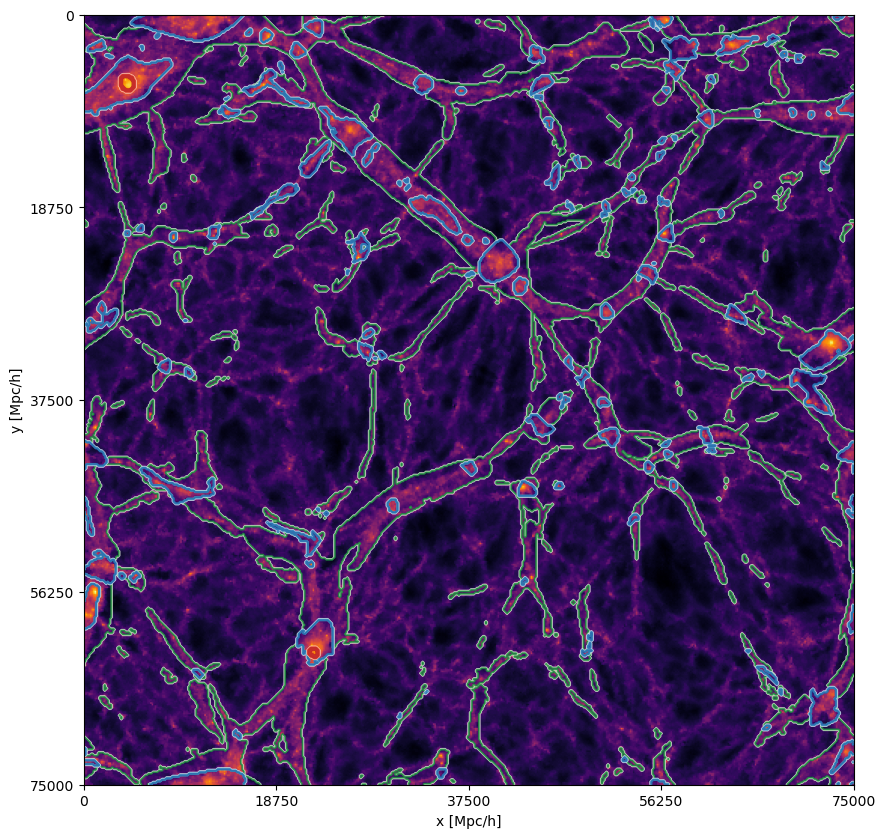

In [39]:
i2 = 200

x, y = np.meshgrid(np.linspace(0,sidelen,gridsize),np.linspace(0,sidelen,gridsize))
fig = plt.figure(figsize=(10,10))
im = plt.imshow(np.log(denfield[:,i2,:]),cmap="inferno",extent=[0,sidelen,sidelen,0])
plt.contour(x,y,MMFw[:,i2,:],level=1,cmap="Greens",linewidths=1,alpha=0.5)
plt.contour(x,y,MMFf[:,i2,:],level=1,cmap="Blues",linewidths=1.5,alpha=0.5)
plt.contour(x,y,MMFn[:,i2,:],level=1,cmap="Reds",linewidths=3,alpha=0.5)
new_ticks = np.linspace(0, sidelen, 5)  # Positions on the original scale
rescaled_ticks = np.linspace(0, 75_000, 5)  # Rescaled tick labels

# Update tick settings to match the extent of the plot
plt.xticks(new_ticks, [f"{int(tick)}" for tick in rescaled_ticks])
plt.yticks(new_ticks, [f"{int(tick)}" for tick in rescaled_ticks])


plt.xlabel("x [Mpc/h]")
plt.ylabel("y [Mpc/h]")
# plt.title(f"Density Field slice at snapshot {snapnum}", size=15)
plt.show()

In [16]:
def getMorphologicalIDs():
    """
    returns:
    
    f_ids: ids of particles in filaments
    w_ids: ids of particles in walls
    n_ids: ids of particles in nodes
    v_ids: ids of particles in voids
    """
    
    
    maskMMFf = np.where(MMFf>0, 1, 0)
    maskMMFw = np.where(MMFw>0, 1, 0)
    maskMMFn = np.where(MMFn>0, 1, 0)
    maskMMFv = np.where((MMFf == 0) & (MMFw == 0) & (MMFn == 0), 1, 0)
    
    maskf = generateMask(positions_grid, maskMMFf)
    maskw = generateMask(positions_grid, maskMMFw)
    maskn = generateMask(positions_grid, maskMMFn)
    maskv = generateMask(positions_grid, maskMMFv)
    
    f_ids = ids_array[maskf == 1]
    w_ids = ids_array[maskw == 1]
    n_ids = ids_array[maskn == 1]
    v_ids = ids_array[maskv == 1]
    
    return f_ids, w_ids, n_ids, v_ids

In [17]:
filaments, walls, nodes, voids = getMorphologicalIDs()

In [35]:
particle_id_dict = {
    'filaments': filaments,
    'walls': walls,
    'nodes': nodes,
    'voids': voids,
    'il_data': snap
}

In [37]:
# with open(f'/Users/users/nastase/PROJECT/DATA/nexus_outputs/particle_selecta/particle_ids_{snapnum}.pickle', 'wb') as handle:
#     pickle.dump(particle_id_dict, handle, protocol=4)

In [4]:
# with open(f'/Users/users/nastase/PROJECT/DATA/nexus_outputs/particle_selecta/particle_ids_{snapnum}.pickle', 'rb') as handle:
#     loaded_ids_dict = pickle.load(handle)

In [30]:
def determine_particle_label(id_val, filaments, walls, nodes, voids):
    if id_val in filaments:
        return 'f'
    elif id_val in walls:
        return 'w'
    elif id_val in nodes:
        return 'n'
    elif id_val in voids:
        return 'v'
    else:
        return None  # In case the ID is not in any array

In [62]:
df_array = pd.DataFrame(index = ids_array)

In [63]:
df_array

""
88038007
88173007
3638407
3439732
81301332
...
94196367
94196368
94196369
94196373


In [64]:
# filament_ids_set = set(particle_id_dict['filaments'])
# walls_ids_set = set(particle_id_dict['walls'])
# nodes_ids_set = set(particle_id_dict['nodes'])
# voids_ids_set = set(particle_id_dict['voids'])

In [40]:
df[f"particle_type_{snapnum}"] = df.index.map(lambda x: determine_particle_label(x, 
                                                filament_ids_set, 
                                                walls_ids_set, 
                                                nodes_ids_set, 
                                                voids_ids_set)
            )

In [41]:
# with open(f'/Users/users/nastase/PROJECT/DATA/nexus_outputs/particle_selecta/particle_types_dataframe_{snapnum}.pickle', 'wb') as handle:
#     pickle.dump(df, handle, protocol=4)

In [50]:
with open(f'/Users/users/nastase/PROJECT/DATA/nexus_outputs/particle_selecta/particle_types_dataframe_{snapnum}.pickle', 'rb') as handle:
    loaded_types_df = pickle.load(handle)

In [48]:
df1 = loaded_types_df

In [51]:
df2 = loaded_types_dfes_df

In [52]:
df1.join(df2)

,particle_type_135,particle_type
3454907,n,n
88038007,n,n
3454932,n,n
88043982,n,n
2455757,n,n
...,...,...
94196367,v,v
94196368,v,v
94196369,f,f
94196373,w,w


In [65]:
df[df["particle_type"] == "f"]

,particle_type
15676632,f
87471556,f
84416862,f
87435081,f
2920282,f
...,...
94196356,f
94196357,f
94196360,f
94196362,f
